In [2]:
import os
import json
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import torch
import numpy as np
from Scripts.assignLabel import assign_label
import tensorboard

In [ ]:

from assignLabel import assign_label
un_dir = 'unlabeled'
for un_file in os.listdir(un_dir):
    assign_label(os.path.join(un_dir, un_file))


In [4]:
# load data from jsonl files
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokens = []
labels = []
data_dir = "TrainTestData"

for an_file in sorted(os.listdir(data_dir), key= lambda x: int(x[4:].strip(".jsonl"))):
    print(an_file)
    jsonl_data = os.path.join(data_dir, an_file)
    with open (jsonl_data, 'r', encoding="utf-8") as file:
        for line in file:
            data = json.loads(line)
            tokens.append(data['text'])
            labels.append(data['label'])
df = pd.DataFrame({'tokens': tokens, 'labels': labels})




data1.jsonl
data2.jsonl
data3.jsonl
data4.jsonl
data5.jsonl
data6.jsonl
data7.jsonl
data8.jsonl
data9.jsonl
data10.jsonl
data11.jsonl


In [5]:
# chose the model, tokenizer and labels
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

entity_labels = {
    "OTHER": 0,
    "PRODUCT": 1
}

label_list = list(entity_labels.keys())
# label_list
print(df.head)

<bound method NDFrame.head of                                      tokens  \
0     Amanda cockfighting chair -  32590.99   
1                            Clark cupboard   
2                    Molly vargueno -  2339   
3                            Ted ogee clock   
4                                Rosa bench   
...                                     ...   
3648                                      2   
3649                                      3   
3650                                      4   
3651                                   Next   
3652                                   Last   

                                   labels  
0     [[0, 25, PRODUCT], [25, 37, OTHER]]  
1                      [[0, 14, PRODUCT]]  
2     [[0, 14, PRODUCT], [14, 22, OTHER]]  
3                      [[0, 14, PRODUCT]]  
4                      [[0, 10, PRODUCT]]  
...                                   ...  
3648                      [[0, 1, OTHER]]  
3649                      [[0, 1, OTHER]]  
3650     

In [6]:
# tokenize inputs and assign labels
labels = []
tokenized_inputs = tokenizer(df["tokens"].tolist(), truncation=True, padding=True, max_length=120)
# for each input, assign the labels to the corresponding token based on the number of tokens that the input was split into
for i, label in enumerate(df["tokens"]):
    input_ids = tokenized_inputs["input_ids"][i]
    current_labels = []
    # to each id assign the corresponding label
    for input_id in input_ids:
        # -100 for the sentence start token
        if input_id == 101:
            current_labels.append(-100)
        else:
            # for each label in labels list for this input, assign the corresponding label to the tokens if they are part of the original input
            for label_int in df["labels"][i]:
                # take the number of tokens that the input was split into for the current label
                tokenized_input = tokenizer(df["tokens"][i][label_int[0]:label_int[1]], truncation=True, max_length = 120)
                # substract 2 for the sentence start and end tokens as they are treated separately
                current_labels.extend([entity_labels[label_int[2]]]  * (len(tokenized_input["input_ids"]) - 2))
            break
    # -100 for the sentence end token and padding tokens
    for input_id in input_ids:
        if input_id == 0 or input_id == 102:
            current_labels.append(-100)
    labels.append(current_labels[:120])

df["labels"] = labels


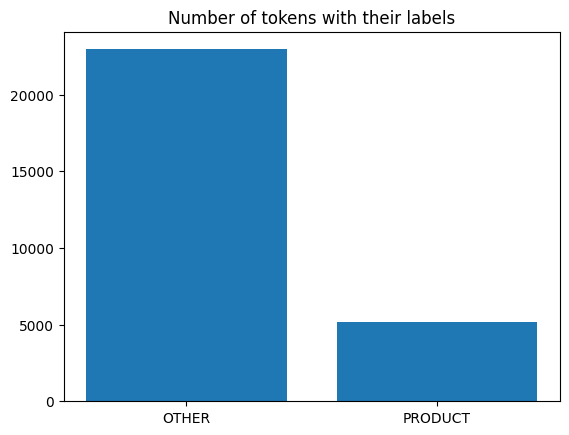

In [149]:
import matplotlib.pyplot as plt
num_OTHER = sum(cell == 0 for row in df["labels"] for cell in row)
num_PRODUCT = sum(cell == 1 for row in df["labels"] for cell in row)
labels_num = [num_OTHER, num_PRODUCT]
plt.bar(["OTHER", "PRODUCT"], labels_num)
plt.title("Number of tokens with their labels")
plt.show()


In [7]:
from sklearn.model_selection import train_test_split
tokenized_inputs["labels"] = labels
# split the dataset in train and test
train_dataset = Dataset.from_dict(tokenized_inputs)
train_dataset, test_dataset = train_test_split(train_dataset, test_size=0.3, shuffle=True)
train_dataset = Dataset.from_dict(train_dataset)
# train_dataset = train_dataset.shuffle()

test_dataset = Dataset.from_dict(test_dataset)

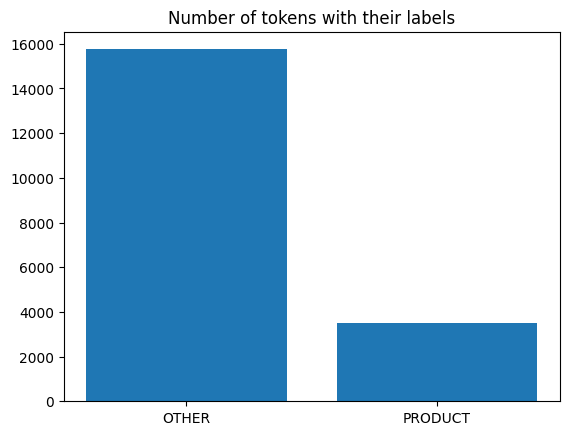

In [153]:
num_OTHER = sum(cell == 0 for row in train_dataset["labels"] for cell in row)
num_PRODUCT = sum(cell == 1 for row in train_dataset["labels"] for cell in row)
labels_num = [num_OTHER, num_PRODUCT]
plt.bar(["OTHER", "PRODUCT"], labels_num)
plt.title("Number of tokens with their labels")
plt.show()


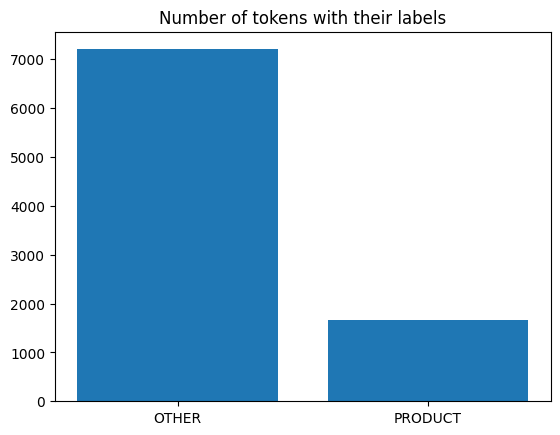

In [154]:
num_OTHER = sum(cell == 0 for row in test_dataset["labels"] for cell in row)
num_PRODUCT = sum(cell == 1 for row in test_dataset["labels"] for cell in row)
labels_num = [num_OTHER, num_PRODUCT]
plt.bar(["OTHER", "PRODUCT"], labels_num)
plt.title("Number of tokens with their labels")
plt.show()

In [8]:
from datasets import load_metric
# load the model
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels = len(entity_labels))
# set the training arguments
args = TrainingArguments(
    "test-ner",
    evaluation_strategy = "epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=7,
    weight_decay=0.01,
    report_to="tensorboard"
)

# used to batch the data
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load_metric("seqeval")

def compute_metrics(p):
    predictions, labels = p
    # highest probability label
    predictions = np.argmax(predictions, axis=2)

    # match the predictions to the labels and remove the unrelevant tokens
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\gheto\AppData\Local\Temp\ipykernel_16928\2217316236.py:18: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [9]:
trainer = Trainer(
    model,
    args,
    train_dataset= train_dataset,
    eval_dataset= test_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()
trainer.evaluate()
trainer.save_model("best-model")

In [116]:
# predict on a new text
model = AutoModelForTokenClassification.from_pretrained("test-ner\checkpoint-500")
tokenizer = AutoTokenizer.from_pretrained("test-ner\checkpoint-500")
sequence = "Buy this new Jakaranda Sofa Green from our store"
tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
inputs = tokenizer.encode(sequence, return_tensors="pt")
outputs = model(inputs)[0]
predictions = torch.argmax(outputs, dim=2)
print([(token, label_list[prediction]) for token, prediction in zip(tokens, predictions[0].tolist())])


[('[CLS]', 'OTHER'), ('buy', 'OTHER'), ('this', 'OTHER'), ('new', 'OTHER'), ('ja', 'PRODUCT'), ('##kara', 'PRODUCT'), ('##nda', 'PRODUCT'), ('sofa', 'PRODUCT'), ('green', 'OTHER'), ('from', 'OTHER'), ('our', 'OTHER'), ('store', 'OTHER'), ('[SEP]', 'OTHER')]


In [ ]:
pred_data_dir = "DataToPredict"
products = dict()
nr = 0
for file in sorted(os.listdir(pred_data_dir), key=lambda x : int(x.rsplit('.', 1)[0].rsplit('_',1)[1])):
    print("-----------------------------------")
    print(file)
    nr += 1
    # if nr == 5:
    #     break
    pred_fpath = os.path.join(pred_data_dir, file)
    with open(pred_fpath, 'r', encoding='utf-8') as pred_file:
        for line in pred_file:
            line = line[:120]
            tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(line), max_length=512))
            inputs = tokenizer.encode(line, return_tensors="pt", max_length=512)
            outputs = model(inputs)[0]
            predictions = torch.argmax(outputs, dim=2)
            token_pred = [(token, label_list[prediction]) for token, prediction in zip(tokens, predictions[0].tolist())]
            product = ""
            # print(token_pred)
            for token, pred_label in token_pred:
                if pred_label == 'PRODUCT':
                    if token not in ["[CLS]", "", "[SEP]"]:
                        if token[0] == '#' and token[1] == '#':
                            product += token[2:]
                        else:
                            product += " " + token
            if product:
                print(product)
                products[product] = product

json_products = json.dumps(products)
with open("occurences.json", 'w') as file_occ:
    file_occ.write(json_products)
products_df = pd.DataFrame.from_dict(products, orient='index')
products_df.to_csv('extractedData.csv', index = [0])



In [ ]:
from collections import Counter
def number_of_occurrences(predicted_products):
    most_common = ['bed', "sofa", "table", "chair", "bed", "wardrobe", "desk", "lamp", "shelf", "couch", "chest", "mirror", "carpet"]
    all_words = ' '.join(predicted_products).split()
    nr_occurrences = Counter(all_words)
    most_common_occ = {}
    for obj in most_common:
        most_common_occ[obj] = nr_occurrences.get(obj, 0)

    print(most_common_occ)
    return most_common_occ